# Problem description
The goal of this project is to build a GAN that generates monet style images.

Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## Data description
The data is donwloaded from https://www.kaggle.com/competitions/gan-getting-started/data competition. It is composed by the following files and folders:
- monet_jpg: This contains the monet style images in jpg format
- monet_tfrec: This contains the monet style images in jpg in TFRecord format
- photo_jpg: This contains photos in jpg format
- photo_tfrec: This contains photos in jpg in TFRecord format

Let's explore the jpg format files:

In [8]:
import pandas as pd

In [9]:
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'

In [10]:
print('Number of images in folder monet_jpg:')
print(len(os.listdir(monet_path)))
print('*'*100)
print('Number of images in folder photo_jpg:')
print(len(os.listdir(photo_path)))

Number of images in folder monet_jpg:
300
****************************************************************************************************
Number of images in folder photo_jpg:
7038


In [5]:
img_monet = Image.open(os.path.join(monet_path, os.listdir(monet_path)[0]))
print('Shape of Monet images:')
print(np.array(img_monet).shape)

Shape of Monet images:
(256, 256, 3)


In [6]:
img_photo = Image.open(os.path.join(photo_path, os.listdir(photo_path)[0]))
print('Shape of photo images:')
print(np.array(img_photo).shape)

Shape of photo images:
(256, 256, 3)


As we can see they are the same shape 3 channels and 256 x 256

In [33]:
def plot_images(path, n_images=10, title=''):
    images_paths = pd.Series(os.listdir(path)).sample(n_images).values
    
    # Calculate the number of rows and columns
    w = int(np.sqrt(n_images))
    h = int(np.ceil(n_images / w))
    
    # Crear figura
    plt.figure(figsize=(12, 8))
    
    for i, file in enumerate(images_paths):
        img = Image.open(os.path.join(path, file)).convert("RGB")
        img = img.resize((128, 128))
        
        plt.subplot(h, w, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i}', fontsize=8)
    
    plt.suptitle(title, fontsize=16)
    plt.show()


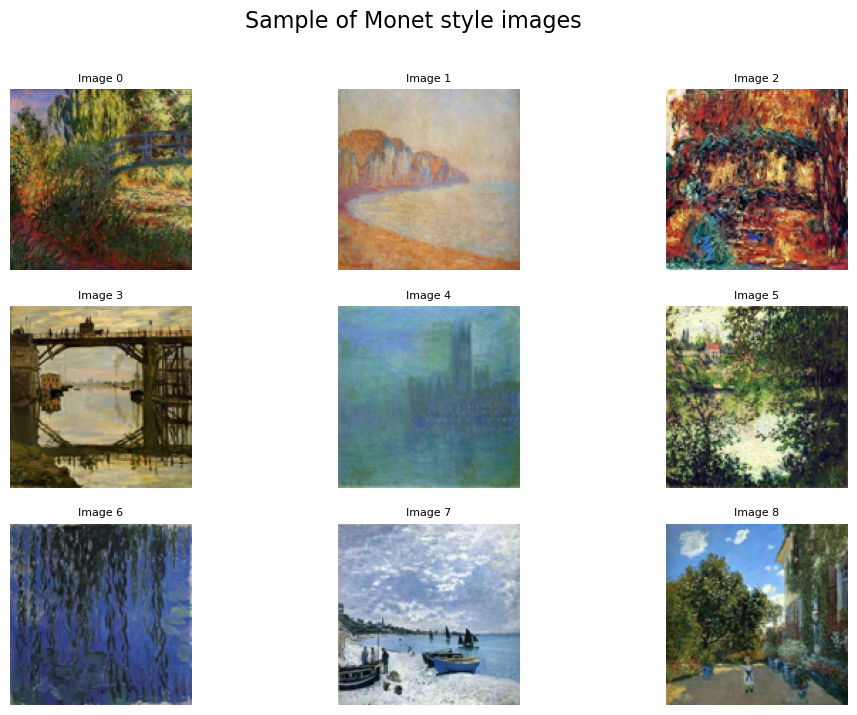

In [32]:
plot_images(monet_path, n_images=9, title='Sample of Monet style images')

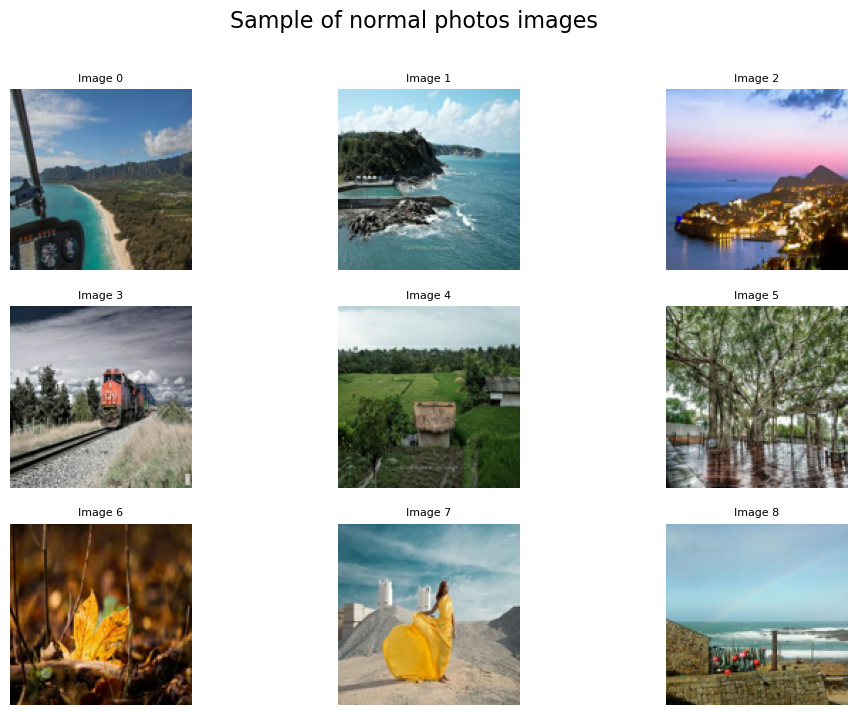

In [34]:
plot_images(photo_path, n_images=9, title='Sample of normal photos images')

## Exploratory Data Analysis

First, let's analyze the color distribution for each class of images

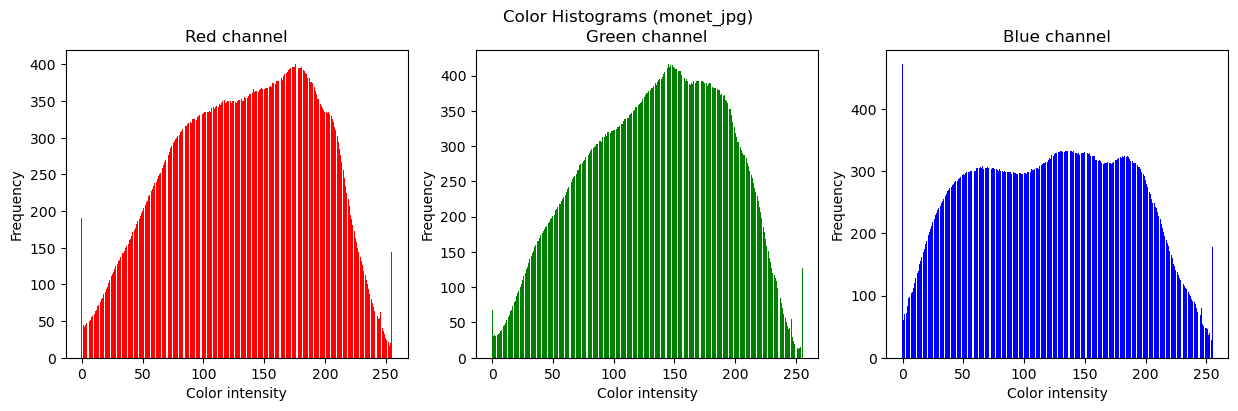

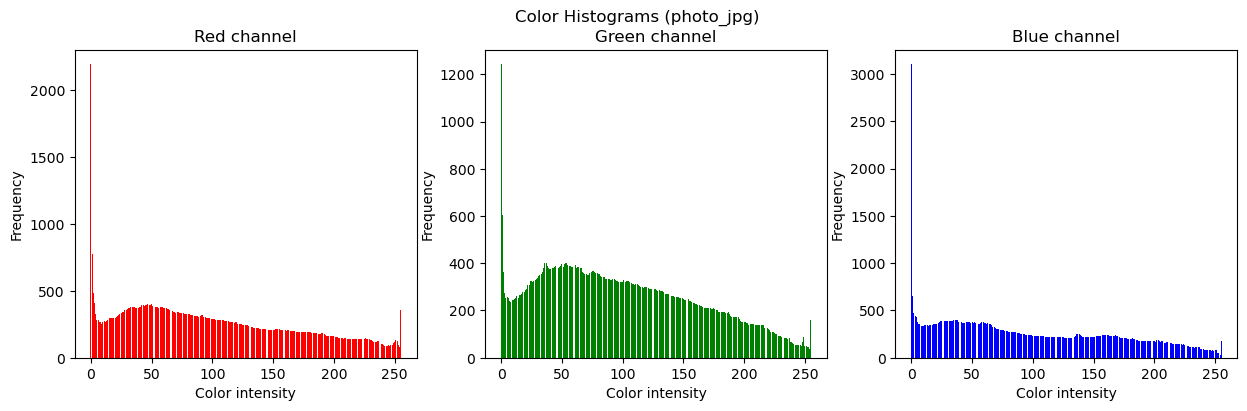

In [46]:
def plot_color_histograms(path, n=200):
    imgs = pd.Series(os.listdir(path)).sample(n).values
    
    # Inicialize histigrams
    hist_r, hist_g, hist_b = np.zeros(256), np.zeros(256), np.zeros(256)
    
    for img_name in imgs:
        img = Image.open(os.path.join(path, img_name)).convert("RGB")
        arr = np.array(img)
        
        hist_r += np.histogram(arr[..., 0], bins=256, range=(0,255))[0]
        hist_g += np.histogram(arr[..., 1], bins=256, range=(0,255))[0]
        hist_b += np.histogram(arr[..., 2], bins=256, range=(0,255))[0]
    
    # Average
    hist_r /= n
    hist_g /= n
    hist_b /= n
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    axes[0].bar(range(256), hist_r, color='red')
    axes[0].set_title('Red channel')
    axes[1].bar(range(256), hist_g, color='green')
    axes[1].set_title('Green channel')
    axes[2].bar(range(256), hist_b, color='blue')
    axes[2].set_title('Blue channel')
    
    for ax in axes:
        ax.set_xlabel('Color intensity')
        ax.set_ylabel('Frequency')
    
    plt.suptitle(f'Color Histograms ({path.split("/")[-1]})')
    plt.show()

# Plot the two distributions for each image type
plot_color_histograms("monet_jpg")
plot_color_histograms("photo_jpg")

- The Monet style images use intermediate values in the color intensity in the three colors, which makes sense as the Monet style images use softer colors compared to the real photos.

- Also in the Monet the three colors are balanced, and in the real photos the green channel has more frequency.

Now, let's analyze it with the mean and standar deviation

In [76]:
def mean_std_dataset(path, n=200):
    imgs = pd.Series(os.listdir(path)).sample(n).values
    means, stds = [], []
    for img in imgs:
        arr = np.array(Image.open(os.path.join(path, img))).astype(np.float32) / 255
        means.append(arr.mean(axis=(0,1)))
        stds.append(arr.std(axis=(0,1)))
    return np.mean(means, axis=0), np.mean(stds, axis=0)

In [77]:
mean_monet, std_monet = mean_std_dataset("monet_jpg")
mean_real, std_real = mean_std_dataset("photo_jpg")
print("Monet mean of colors (RGB):", mean_monet)
print("Photos mean of colors (RGB):", mean_real)


Monet mean of colors (RGB): [0.5114057  0.5155834  0.47022775]
Photos mean of colors (RGB): [0.39725852 0.4026491  0.37877283]


- We can see that the Monet images use the three colors more balanced comoared to the photos, as in the histograms.

In [78]:
print("Monet standard deviation of colors (RGB):", std_monet)
print("Photos standard deviation of colors (RGB):", std_real)


Monet standard deviation of colors (RGB): [0.18814749 0.17900383 0.19000164]
Photos standard deviation of colors (RGB): [0.22269452 0.19860221 0.21950206]


- The standar deviation for the monet images is lower in all the three color channels. This means that the photos have higher variability in the colors, which makes sense as they are real photos on the real world, so the detail is higher compared to Monet images.

## Data preparation
In this section I'll prepare the data with Pytorch.

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [12]:
class ImageDataset(Dataset):
    def __init__(self, monet_path, photo_path):
        self.image_transformer = transforms.Compose([
                            transforms.Resize(256),
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5)
                        ])
        self.root_monet = monet_path
        self.root_photo = photo_path
        
        self.monet_images = os.listdir(self.root_monet)
        self.photo_images = os.listdir(self.root_photo)
        
        # Calculate images paths
        self.monet_paths = [os.path.join(self.root_monet, f) for f in self.monet_images]
        self.photo_paths = [os.path.join(self.root_photo, f) for f in self.photo_images]
        
        self.monet_len = len(self.monet_paths)
        self.photo_len = len(self.photo_paths)
        self.length_dataset = max(self.monet_len, self.photo_len)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        monet_path = self.monet_paths[idx % self.monet_len]
        photo_path = self.photo_paths[idx % self.photo_len]
        
        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')
        

        monet_img = self.image_transformer(monet_img)
        photo_img = self.image_transformer(photo_img)
        
        return monet_img, photo_img


In [13]:
images_dataset = ImageDataset(monet_path='monet_jpg', photo_path='photo_jpg')

I'll use a batch of 1, each update of the generator and discriminator reflects exactly one image, which helps the model learn fine-grained style and texture details. Larger batches could average multiple styles in one update, making training harder.

In [14]:
data_loader = DataLoader(images_dataset, batch_size=1, shuffle=True)

## Model architecture
I followed the model architecture of the CycleGAN paper. Which consist of the following:
- Generator
    - Downsampling/Encoding layers
    - 6 residuals blocks
    - Upsampling layers to reconstruct the original image size
- Discriminator
    - Convolution of 64
    - Convolution of 128
    - Convolution of 256
    - Convolution of 512
    - Convolution to produce 1 dimensional output for preduction

In [15]:
import torch
import torch.nn as nn

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

This residual block helps to transform from one style to another. Monet -> Photo, and viceversa.

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, n_filters):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            # Initial convolution, output the same size as input
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, stride=1, padding=1),  
            # This normalizes each image per channel
            nn.InstanceNorm2d(n_filters),
            nn.ReLU(),
            # Apply the same convolution
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, x):
        # Add the input after convolutions, as residual block states
        return torch.relu(self.conv(x) + x)

In [29]:

class Generator(nn.Module):
    def __init__(self, n_filters=64, n_residual_blocks=6):
        super(Generator, self).__init__()
        layers = []
        
        # Downsampling/Encoding layers
        layers.extend([
            # Apply the first convolution, normalization and ReLU
            nn.Conv2d(in_channels=3, out_channels=n_filters, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(n_filters), 
            nn.ReLU(True),
            # Apply second convolution
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters * 2, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(n_filters * 2),
            nn.ReLU(True),
            # Apply the third convolution
            nn.Conv2d(in_channels=n_filters * 2, out_channels=n_filters * 4, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(n_filters * 4),
            nn.ReLU(True)
        ])
        
        # Now, we add the residual blocks
        for i in range(n_residual_blocks):
            layers.append(ResidualBlock(n_filters * 4))
        

        # This parts reconstruct to the original image size
        layers.extend([

            nn.ConvTranspose2d(in_channels=n_filters * 4, out_channels=n_filters * 2 * 4, kernel_size=3, stride=1, padding=1),
            # Rearranges elements
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(n_filters * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=n_filters * 2, out_channels=n_filters * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(n_filters),
            nn.ReLU(True),
    
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=n_filters, out_channels=3, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
            
        ])
        # Finally put all together into Sequencial
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

Now, let's define the dismcriminator

In [30]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, n_filters=64):
        super(Discriminator, self).__init__()
        self.init = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=n_filters, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters, out_channels=n_filters * 2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters * 2, out_channels=n_filters * 4, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.InstanceNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters * 4, out_channels=n_filters * 8, kernel_size=4, stride=1, padding=1), 
            nn.InstanceNorm2d(n_filters * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters * 8, out_channels=1, kernel_size=4, stride=1, padding=1), 
            
            nn.Sigmoid()
            
        )

    def forward(self, x):
        prediction = self.init(x)
        return prediction

Let's define the two generators and two discriminators

In [31]:
discriminator_monet = Discriminator().to(device)
discriminator_photo = Discriminator().to(device)

generator_of_monet_images = Generator().to(device)
generator_of_photos_images = Generator().to(device)

The optimizers for discriminators and generators

In [32]:

optimizer_discriminators = torch.optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optimizer_generators = torch.optim.Adam(
    list(generator_of_monet_images.parameters()) + list(generator_of_photos_images.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)



- L1 loss for compare images
- MSE loss for the discriminator prediction

In [33]:
l1_loss = nn.L1Loss()
MSE_loss = nn.MSELoss()

# Training 
Here in the training code I explain in detail how the training works.
- Basically, there are two generators and two discriminators, one for each class: Monet and Photos.


- The CycleGAN basically learns to translate images from one domain to the other while preserving content.
It uses adversarial loss to make generated images realistic, and cycle-consistency loss to ensure the 
translation can be reversed 

- (e.g., Photo → Monet → Photo should reconstruct the original Photo).


In [42]:
import torchvision

  0%|          | 0/7038 [00:00<?, ?it/s]

[Epoch 1/2] [Batch 0/7038][Discriminator total loss: 0.1009] [Generators total loss: 5.0768][Cycle loss: 0.3272][Identity loss: 0.3700]


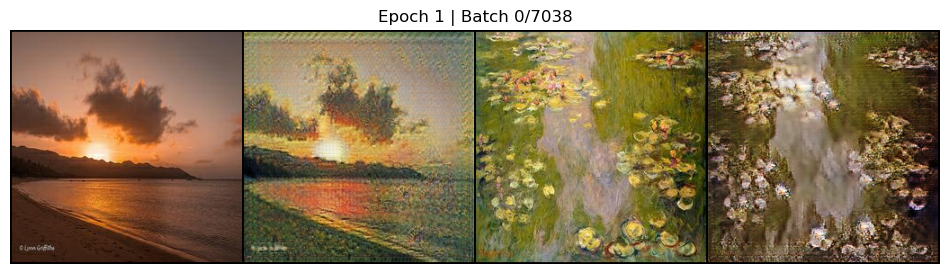

 71%|███████   | 5000/7038 [11:35<04:46,  7.10it/s]

[Epoch 1/2] [Batch 5000/7038][Discriminator total loss: 0.0512] [Generators total loss: 3.7356][Cycle loss: 0.1888][Identity loss: 0.2604]


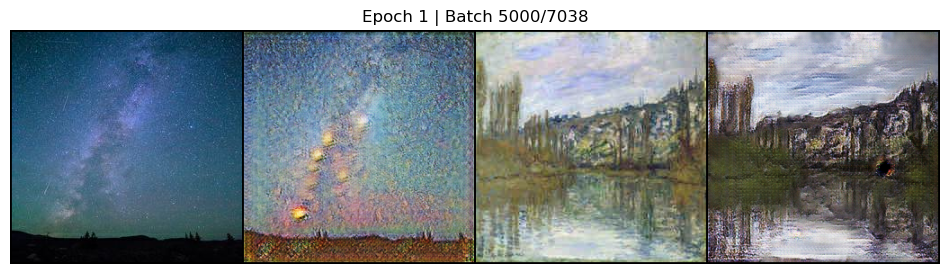

  0%|          | 0/7038 [00:00<?, ?it/s]           

[Epoch 2/2] [Batch 0/7038][Discriminator total loss: 0.2910] [Generators total loss: 4.0845][Cycle loss: 0.2395][Identity loss: 0.2624]


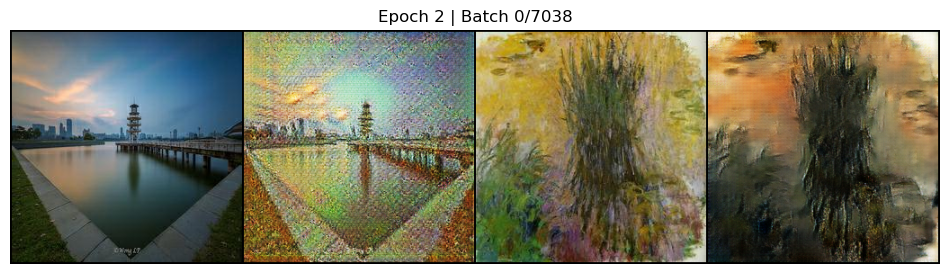

 71%|███████   | 5000/7038 [11:45<04:47,  7.09it/s]

[Epoch 2/2] [Batch 5000/7038][Discriminator total loss: 0.2402] [Generators total loss: 3.8026][Cycle loss: 0.2061][Identity loss: 0.2825]


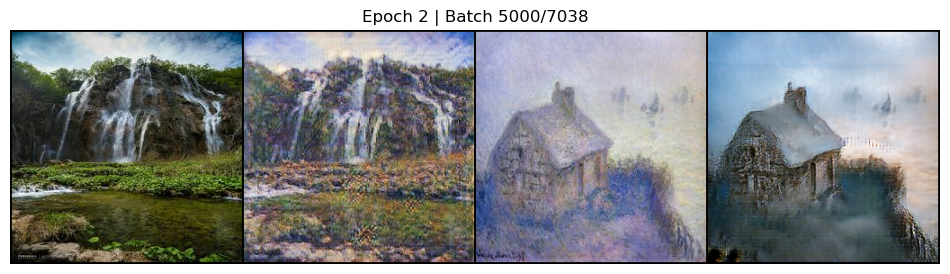

In [27]:
num_epochs = 2

# Weight of the cycle loss (is recomendated in the paper)
lambda_cycle = 10
# Weight of the indentity loss
lambda_identity = 0.5

for epoch in range(num_epochs):
    loop = tqdm(data_loader, leave=False)
    for idx, (monet_image, photo_image) in enumerate(loop):
        monet_image = monet_image.to(device)
        photo_image = photo_image.to(device)

        #-----------------  Discriminators training ------------------------

        # Generate fake images based on the contrary image. Photo -> fake Monet
        fake_photo = generator_of_photos_images(monet_image)
        fake_monet = generator_of_monet_images(photo_image)

        #### Photo discriminator
        real_photo_pred = discriminator_photo(photo_image)
        fake_photo_pred = discriminator_photo(fake_photo.detach())

        # We want the photo discriminator to classify correctly: 1 for real photo, 0 for fake photo
        real_photo_loss = MSE_loss(real_photo_pred, torch.ones_like(real_photo_pred))
        fake_photo_loss = MSE_loss(fake_photo_pred, torch.zeros_like(fake_photo_pred))
        D_photo_loss = (real_photo_loss + fake_photo_loss) * 0.5

        ### Monet discriminator
        real_monet_pred = discriminator_monet(monet_image)
        fake_monet_pred = discriminator_monet(fake_monet.detach())
        
        # The same, we want the monet discriminator classify correctly
        real_monet_loss = MSE_loss(real_monet_pred, torch.ones_like(real_monet_pred))
        fake_monet_loss = MSE_loss(fake_monet_pred, torch.zeros_like(fake_monet_pred))
        D_monet_loss = (real_monet_loss + fake_monet_loss) * 0.5

        # Total loss of the two discriminators
        discriminators_total_loss = D_photo_loss + D_monet_loss

        # Set gradients to zero, because Pytorch acumulates the previous ones.
        optimizer_discriminators.zero_grad()
        # Calculate the gradients respect to the total discriminators loss
        discriminators_total_loss.backward()
        # Finally update the parameters based on the gradients calculated with loss.backward()
        optimizer_discriminators.step()

        #-------------  Generators training -----------------
        fake_photo_pred = discriminator_photo(fake_photo)
        fake_monet_pred = discriminator_monet(fake_monet)

        # Here we want generator --fool the discriminator--, thats why I set ones at fake images
        generator_photo_loss = MSE_loss(fake_photo_pred, torch.ones_like(fake_photo_pred))
        generator_monet_loss = MSE_loss(fake_monet_pred, torch.ones_like(fake_monet_pred))

        # Now, let's reconstruct the original image based on the fake one
        # photo - > Generator(photo) - > fake monet -> Generator(fake monet) -> reconstructed photo
        # So, we want that photo being the most similar to reconstructed photo
        reconstructed_photo = generator_of_photos_images(fake_monet)
        reconstructed_monet = generator_of_monet_images(fake_photo)
        # Check how different are the original vs reconstructed image
        cycle_photo_loss = l1_loss(photo_image, reconstructed_photo)
        cycle_monet_loss = l1_loss(monet_image, reconstructed_monet)

        # Identity loss. Here, we want the generator to preserve 
        # the original characteristics of their image class
        identity_photo = generator_of_photos_images(photo_image)
        identity_monet = generator_of_monet_images(monet_image)
        identity_photo_loss = l1_loss(photo_image, identity_photo)
        identity_monet_loss = l1_loss(monet_image, identity_monet)

        # Generators total loss
        generators_total_loss = (
            generator_photo_loss
            + generator_monet_loss
            + lambda_cycle * (cycle_photo_loss + cycle_monet_loss)
            + lambda_identity * (identity_photo_loss + identity_monet_loss)
        )

        # Update the generators weights the same as discriminator
        optimizer_generators.zero_grad()
        generators_total_loss.backward()
        optimizer_generators.step()

        # Monitor the training
        if idx % 5000 == 0:
            print(
                f"[Epoch {epoch+1}/{num_epochs}] [Batch {idx}/{len(data_loader)}]"
                f"[Discriminator total loss: {discriminators_total_loss.item():.4f}] "
                f"[Generators total loss: {generators_total_loss.item():.4f}]"
                f"[Cycle loss: {(cycle_photo_loss + cycle_monet_loss).item():.4f}]"
                f"[Identity loss: {(identity_photo_loss + identity_monet_loss).item():.4f}]"
            )
            with torch.no_grad():
                sample_fake_photo = generator_of_photos_images(monet_image[:4])
                sample_fake_monet = generator_of_monet_images(photo_image[:4])

                # Creat an image grid
                images_to_show = torch.cat(
                    (photo_image[:4], sample_fake_monet, monet_image[:4], sample_fake_photo), 0
                )
                images_to_show = images_to_show.cpu()

                # Plot 
                grid_img = torchvision.utils.make_grid(images_to_show, nrow=4, normalize=True)
                plt.figure(figsize=(12, 6))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.axis('off')
                plt.title(f"Epoch {epoch+1} | Batch {idx}/{len(data_loader)}")
                plt.show()

## Save models

In [29]:
torch.save(generator_of_photos_images.state_dict(), f"models/generator_photo_epoch_{num_epochs}.pth")
torch.save(generator_of_monet_images.state_dict(), f"models/generator_monet_epoch_{num_epochs}.pth")
torch.save(discriminator_photo.state_dict(), f"models/discriminator_photo_epoch_{num_epochs}.pth")
torch.save(discriminator_monet.state_dict(), f"models/discriminator_monet_epoch_{num_epochs}.pth")

## Results
I'll generate some monet images in order to see how they look.

In [38]:
from torch.utils.data import DataLoader, Subset
import random

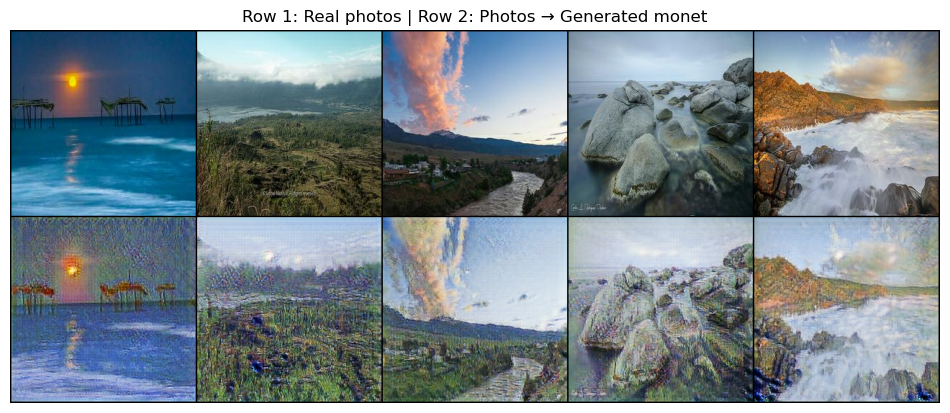

In [45]:
n_samples = 5
indices = random.sample(range(len(images_dataset)), n_samples)
subset = Subset(images_dataset, indices)
loader = DataLoader(subset, batch_size=n_samples, shuffle=False)
monet_images, photo_images = next(iter(loader)) 

photo_images = photo_images.to(device)

# Generate Monet images
fake_monet = generator_of_monet_images(photo_images)

# Prepare the images to plot
images_to_show = torch.cat((photo_images, fake_monet), 0)
images_to_show = images_to_show.cpu()

grid_img = torchvision.utils.make_grid(images_to_show, nrow=n_samples, normalize=True)

# Plot images
plt.figure(figsize=(12, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title("Row 1: Real photos | Row 2: Photos → Generated monet")
plt.show()


They look great!, for me it's super interesting to see how the model learned to do this.

## Generate images
I'll generate the images for the Kaggle prediction

In [70]:
import torchvision
from tqdm import tqdm

for idx, (monet, photo) in enumerate(tqdm(images_dataset)):
    photo = photo.to(device)

    # Generate a monet version of the photo
    monet_generated_image = generator_of_monet_images(photo[None, :]).detach().cpu()

    # Save the image with torchvision
    torchvision.utils.save_image(
        monet_generated_image,
        f"images_monet_generated/{idx}.jpg",
        normalize=True
    )
    if idx == 7100:
        break

7100it [01:02, 114.21it/s]                          


Create the zip folder as Kaggle expects.

In [73]:
import shutil
shutil.make_archive('images', 'zip', 'images_monet_generated/')

'/home/sagemaker-user/my_awesome_model/images.zip'

### Fréchet Inception Distance
Now, I'll calculate the FID, which measures the difference between the original images vs the generated ones.
In Kaggle, they will score my submission based on MiFID (Memorization-informed FID), which penalizes based on how similar are the gemerated images to the training images.

But, for simplicity I'll use FID in order to see the general performance.

To see the diferences between images I'll use the incepction_v3 pretrained model.

In [48]:
from torchvision import models
import torch
import torch.nn.functional as F


# InceptionV3 model pretrained
inception = models.inception_v3(weights="IMAGENET1K_V1", transform_input=False)
inception.fc = torch.nn.Identity()  # Quit the last layer
inception.eval().to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 281MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [74]:
@torch.no_grad()
def get_activations(images, model, device):
    images = images.to(device)
    images = (images + 1) / 2
    pred = model(images)
    return pred.detach().cpu().numpy()


In [76]:
import numpy as np
from scipy import linalg

def calculate_fid(act_real, act_fake):
    # act_real / act_fake
    mu_real = np.mean(act_real, axis=0)
    sigma_real = np.cov(act_real, rowvar=False)

    mu_fake = np.mean(act_fake, axis=0)
    sigma_fake = np.cov(act_fake, rowvar=False)

    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    # If there are complex numbers we'll only the the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the FID
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)

    if np.iscomplexobj(fid):
        fid = fid.real
    return fid


This part is for the ImageFolder from Pytorch, it needs images being in a folder inside the main folder.

In [77]:
import os
import shutil


dummy_class_dir = "images_monet_generated/class0"
os.makedirs(dummy_class_dir, exist_ok=True)

# Mover todas las imágenes jpg a la subcarpeta
for f in os.listdir("images_monet_generated"):
    if f.endswith(".jpg"):
        shutil.move(os.path.join("images_monet_generated", f), os.path.join(dummy_class_dir, f))


In [78]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Use the same transformation as in training
transform_eval = transforms.Compose([
                    transforms.Resize(256),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)
                ])


# Load the generated monet images
fake_dataset = ImageFolder(root="images_monet_generated", transform=transform_eval)
fake_loader = DataLoader(fake_dataset, batch_size=16, shuffle=False)


In [79]:
# This is for the real photos images
real_loader = DataLoader(images_dataset, batch_size=16, shuffle=False)

Finally obtain the FID score.

In [80]:
# Obtain the images activations.
real_acts = np.concatenate([get_activations(monet.to(device), inception, device) 
                            for monet, _ in real_loader], axis=0)

fake_acts = np.concatenate([get_activations(x[0].to(device), inception, device)
                            for x in fake_loader], axis=0)

fid_score = calculate_fid(real_acts, fake_acts)
print("FID:", fid_score)


FID: 2.223208113356471e+79


FID reference:
- 0 – 10	Excelent
- 10 – 30	Good (little difference)
- 30 – 50	Acceptable (Visible difference)
- 50 – 100 Poor
-  100 or more	Very low performance

### Color distribution between real monet vs generated monet

Now, let's see the color distribution of the original monet images vs the fake ones.

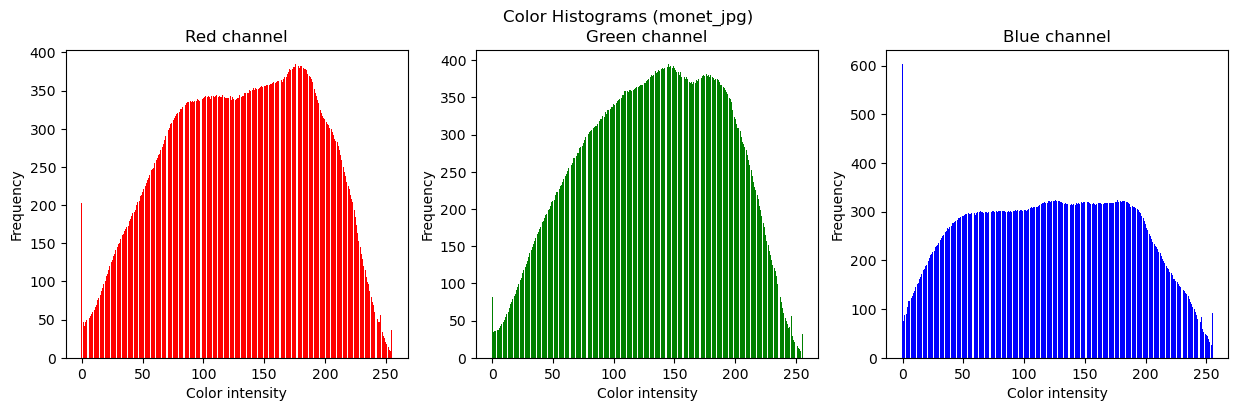

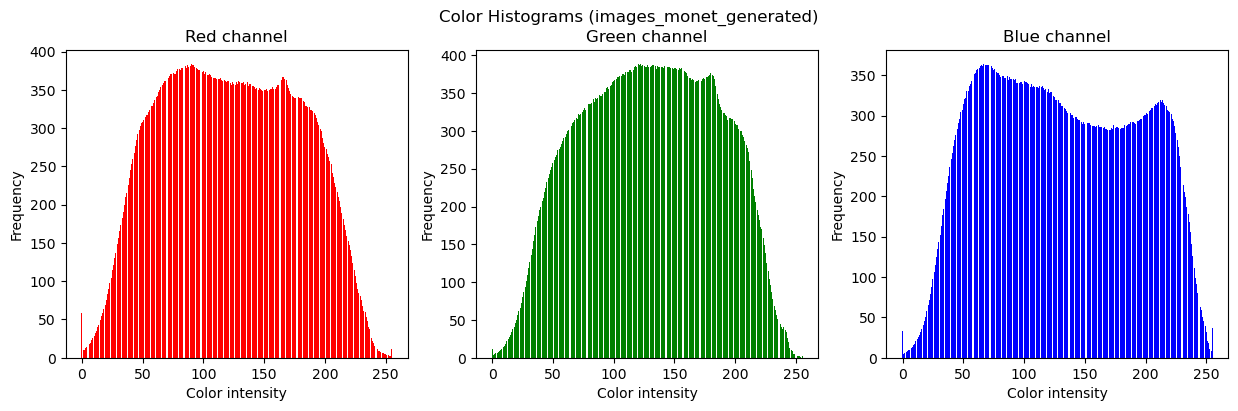

In [47]:
plot_color_histograms("monet_jpg")
plot_color_histograms("images_monet_generated")

## Conclusions
- The FID score is 2.223 which aparently, the monet vs generated monet are very similar, but doesn't take into account the memorization in training images as Kaggle score MiFID.
- After running the code in the Kaggle enviornment I obtained the following public score: 81.20367
- The color distriutions for the real monet and the generated monet images are very similar, which is great as the color distribution for the photos is much diferent compared to monet.

## Next steps:
- As the model architecture is complex and the training time is ~1 hour, maybe doing parameter tuning with optuna for the architecture is not optimal, but I'll try to do with the learnng rate.
- Set a scheduler to control the learning rate for discriminators and generators.
- Do some images transformations like rotation in order to see if that works.